# Exploring the Ising model of atoms and equilibriating

This document explores the Ising model of atoms in a lattice and a method of equilibriation called the Metropolis algorithm. Using this algorithm we will attempt to find a state of equilibrium in the model. 

The model will be rather simplistic, it will describe a lattice of atoms with one of two spins; spin 1/2 or spin -1/2 which will be set randomly across the lattice for the initial conditions. The simulation assumes that the atoms only interact with their direct neighbours in the lattice, in this notebook a magnetic field will not be applied.

As required from the Metropolis algorithm, the trial change in the model will be to switch a random atom's spin with another random atom's spin. If the energy change is negative the switch is accepted, if the energy change is positive we give a probability p that the change is accepted. The equation for this probabliity p is given below:

Equation 1:
$$
p = \exp{ \left ( -\frac{\Delta E}{k_B T} \right )} 
$$

Where $\Delta E$ is the change in energy due to the switch, $k_B$ is the boltzmann constant and T is the temperature in Kelvin. As the increase in energy becomes large it is possible to see from Eq. 1 that the chance the swap between atoms is accepted decreases. The process of allowing changes of increasing energy means that the model can escape from local minima created by the initial conditions, but not from a global minima due to the extensive variables of the model.

The change in energy may be calculated using the equation below:

Equation 2:
$$
E = - \sum_{i} s_i \left ( mB + J \sum_{j} s_j \right )
$$

Where E is the total energy of the lattice, the spins $s_i$ and $s_j$ have a value of (-1 or +1) and m is a 1/2, the absolute value of spins. J is the quantum mechanical exchange coupling between the spins of the atoms and B is the magnetic field the model is in.

The values $B/k_BT$ and $J/k_BT$ will replace the values for the B and J symbols in Eq 2, this means the $k_BT$ denominator in the probability can be removed as it is already in the change in energy. The atom i is each individual atom in the model and atom j are the atom i's direct neighbours.

So to find the change in energy the sum over all atoms is not required as shown in Eq 2, only the sum of the energies of the atoms that are swapped.

With the modelling of equilibriation without a magnetic field, only the coupling between the spins of the atoms, a ferromagnetic behaviour is expected from the lattice if the value of J is large enough.


In [1]:
# Appropriate imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

### Creating initial model of spins and setting values

Here the spins are represented by -1 and 1, these values will be scaled within the calculations to -1/2 and 1/2.

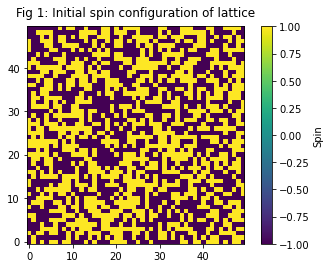

In [2]:
#setting values
boxlen = 50
B_over_kT = 0.0
J_over_kT = 0.5

#creating random 2D array of -1's and 1's
spins = (-1)**np.random.randint(0,2,size=(boxlen,boxlen))

plt.imshow(spins, interpolation='none', origin='lower')
plt.title('Fig 1: Initial spin configuration of lattice',pad=10)
cb = plt.colorbar() 
cb.set_label('Spin')

### Calculating Energy

In [3]:
#collating sum of neighbour spins for each atom
sum_neigh_spins = (np.roll(spins,1,axis=0) + np.roll(spins,-1,axis=0) + 
                    np.roll(spins,1,axis=1) + np.roll(spins,-1,axis=1))

etot1 = -np.sum(spins*(B_over_kT + J_over_kT*sum_neigh_spins))

print("Starting energy (E/kT) is ",etot1)

Starting energy (E/kT) is  -72.0


### Creating a swap function

To do this we have to find an equation for the change in energy when the spins are swapped. Using Eq. 2 above we can find ann equation for the total energy of both atoms, which is given as:

Equation 3:
$$
E_{1} = - s_{1} \left ( mB + J \sum_{j} s_{1j} \right ) - s_{2} \left ( mB + J \sum_{j} s_{2j} \right )
$$

Where $s_1$ and $s_2$ are the spins of atom 1 and 2 resepctively and $s_{1j}$ are $s_{2j}$ the spins of the neighbours of atom 1 & 2 respectively. After the swap, the energy may be given by:

Equation 4:
$$
E_{2} = - s_{2} \left ( mB + J \sum_{j} s_{1j} \right ) - s_{1} \left ( mB + J \sum_{j} s_{2j} \right ) 
$$

With the change in energy being given as:

Equation 5:
$$
\Delta E = E_2 - E_1
$$

As a result, the change in energy before and after the swap may be given by:

Equation 6:
$$
\Delta E = J \left ( \sum_{j} s_{1j} - \sum_{j} s_{2j} \right ) (s_{1} - s_{2})
$$

This is used in the function below. 

Another difficulty in this simulation is the presence of borders, to avoid this issue the simulation will use open boundaries so that the left neighbour to an atom on the far left is the atom on the far right on the same row. This ensures no wierd physical behaviour occurs.

In [4]:
def update_swap(i1,j1,i2,j2,spins):
    """Swaps spin values of two atoms in lattice if the energy change of the swap-
    is negative or if positive there is a probability related to the change in energy-
    this is defined by the metropolis algorithm. Also evaluates the change in energy-
    due to the swap and returns.
    Inputs:
    i1    atom 1 row number
    j1    atom 1 column number  
    i2    atom 2 row number
    j2    atom 2 column number
    spins array of atom spins
    Returns:
    de    Change in energy
    """
    #calculating sum of neighbour spins, modulo to give open boundaries
    i1m1 = (i1-1)%boxlen
    i1p1 = (i1+1)%boxlen
    j1m1 = (j1-1)%boxlen
    j1p1 = (j1+1)%boxlen
    sum_neigh_spins1 = spins[i1m1,j1] + spins[i1p1,j1] + spins[i1,j1m1] + spins[i1,j1p1]
    i2m1 = (i2-1)%boxlen
    i2p1 = (i2+1)%boxlen
    j2m1 = (j2-1)%boxlen
    j2p1 = (j2+1)%boxlen
    
    #calculating spin difference between atoms 1 & 2
    sum_neigh_spins2 = spins[i2m1,j2] + spins[i2p1,j2] + spins[i2,j2m1] + spins[i2,j2p1]
    diff_spins = sum_neigh_spins1 - sum_neigh_spins2
    
    #calculating energy change due to swap
    de = J_over_kT*diff_spins*(spins[i1,j1] - spins[i2,j2])
    p = np.exp(-de)
    
    #swap criteria
    if de < 0 or np.random.rand() < p:
        spin_store = spins[i1,j1]
        spins[i1,j1] = spins[i2,j2]
        spins[i2,j2] = spin_store
    else:
        de = 0.0
    return de

### Running the simulation

Here the atoms will be randomly allowed to swap spin states between another random atom in the lattice. This conserves spins but also mimics the real behaviour of a lattice, these swaps will be repeated for 50,000 steps which will give the lattice time to equilibriate, then it will be possible to see the effect the J/kT value has on the rate of equilibriation.

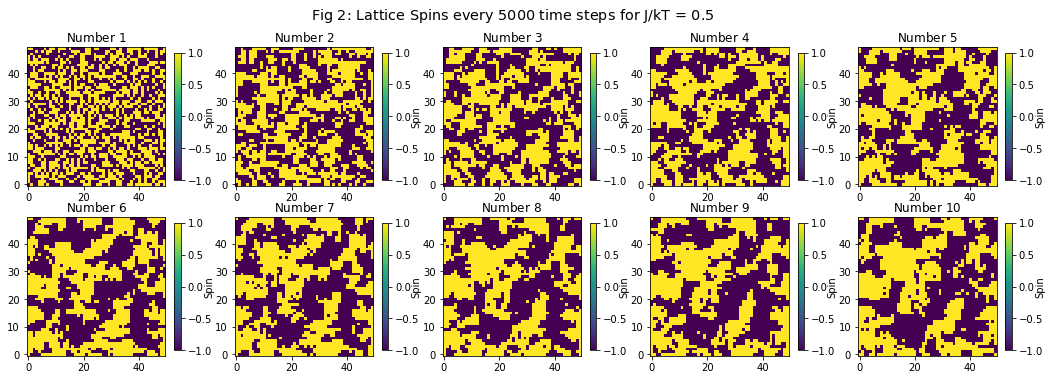

In [5]:
#resets spins each time simulation is run
spins = (-1)**np.random.randint(0,2,size=(boxlen,boxlen))

#initialising
step = 5000 #regularity of plotting
Nsteps = 50000
etot1 = np.zeros(Nsteps+1)
sum_neigh_spins = (np.roll(spins,1,axis=0) + np.roll(spins,-1,axis=0) + 
                        np.roll(spins,1,axis=1) + np.roll(spins,-1,axis=1))
etot1[0] = -np.sum(spins*(B_over_kT + J_over_kT*sum_neigh_spins))
figIsing = plt.figure(figsize=(18,12))
figIsing.suptitle(f'Fig 2: Lattice Spins every ${step}$ time steps for J/kT = 0.5',y=0.925, fontsize='x-large')
index = 1

#monte carlo simulation
for i in range(Nsteps):
    #giving random points in lattice
    this_i1, this_j1 = np.random.randint(0,boxlen,size=2)
    this_i2, this_j2 = np.random.randint(0,boxlen,size=2)
    de = update_swap(this_i1,this_j1,this_i2,this_j2,spins)
    sum_neigh_spins = (np.roll(spins,1,axis=0) + np.roll(spins,-1,axis=0) + 
                        np.roll(spins,1,axis=1) + np.roll(spins,-1,axis=1))
    etot1[i+1] = -np.sum(spins*(B_over_kT + J_over_kT*sum_neigh_spins))
    
    #plotting spins over time
    if i%step==0:
        ax = figIsing.add_subplot(4,5,index)
        im = ax.imshow(spins, interpolation='none', origin='lower')
        cb = figIsing.colorbar(im, ax=ax,shrink=0.9)
        cb.set_label('Spin',labelpad = -8)
        ax.set_title(f'Number ${index}$')
        index +=1 

### Plotting the Total Energy


Text(0.5, 1.0, 'Fig 3: Average energy per atom in the lattice over time')

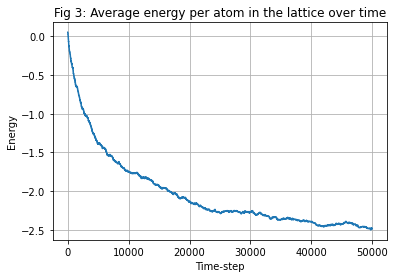

In [6]:
#creating arrays for plotting
iters = np.arange(0,Nsteps+1)
Nspins = boxlen*boxlen
etot_norm1 = etot1/(Nspins * J_over_kT)

#plotting energy over time
plt.plot(iters,etot_norm1)
plt.xlabel('Time-step')
plt.ylabel('Energy')
plt.grid()
plt.title('Fig 3: Average energy per atom in the lattice over time')

### Running Simulation again for a different J/kT value

This time around the same simulation will be run for a value of J/kT = 1, this is a stronger coupling strength and so each swap will effect a larger energy change and should effect the way in which the equilibriation of the lattice occurs. A plot of the spins will be given below to show this process.

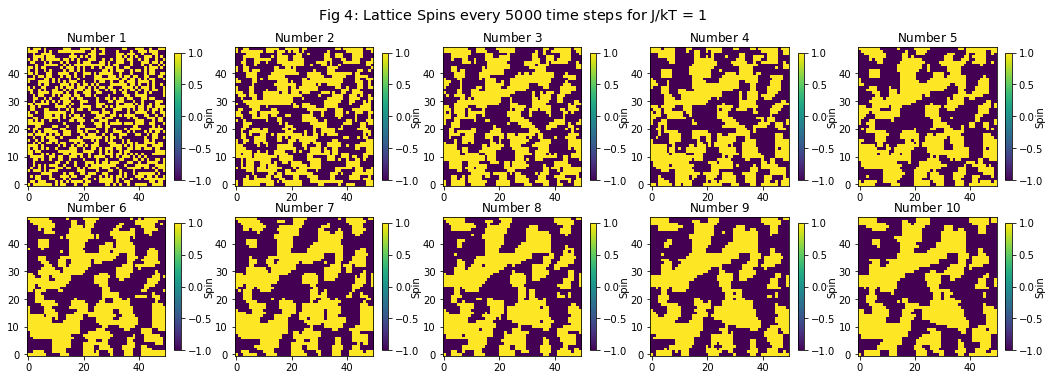

In [7]:
J_over_kT = 1

#random initalisation of spins
spins = (-1)**np.random.randint(0,2,size=(boxlen,boxlen))

#initialising
step = 5000 #regularity of plotting
Nsteps = 50000
etot2 = np.zeros(Nsteps+1)
sum_neigh_spins = (np.roll(spins,1,axis=0) + np.roll(spins,-1,axis=0) + 
                        np.roll(spins,1,axis=1) + np.roll(spins,-1,axis=1))
etot2[0] = -np.sum(spins*(B_over_kT + J_over_kT*sum_neigh_spins))
figIsing = plt.figure(figsize=(18,12))
figIsing.suptitle(f'Fig 4: Lattice Spins every ${step}$ time steps for J/kT = 1',y=0.925, fontsize='x-large')
index = 1

#monte carlo simulation
for i in range(Nsteps):
    #giving random points in lattice
    this_i1, this_j1 = np.random.randint(0,boxlen,size=2)
    this_i2, this_j2 = np.random.randint(0,boxlen,size=2)
    de = update_swap(this_i1,this_j1,this_i2,this_j2,spins)
    sum_neigh_spins = (np.roll(spins,1,axis=0) + np.roll(spins,-1,axis=0) + 
                        np.roll(spins,1,axis=1) + np.roll(spins,-1,axis=1))
    etot2[i+1] = -np.sum(spins*(B_over_kT + J_over_kT*sum_neigh_spins))
    
    #plotting spins over time
    if i%step==0:
        ax = figIsing.add_subplot(4,5,index)
        im = ax.imshow(spins, interpolation='none', origin='lower')
        cb = figIsing.colorbar(im, ax=ax,shrink=0.9)
        cb.set_label('Spin',labelpad = -8)
        ax.set_title(f'Number ${index}$')
        index +=1 


Text(0.5, 1.0, 'Fig 5: Average energy per atom in the lattice over time for both J/kT values')

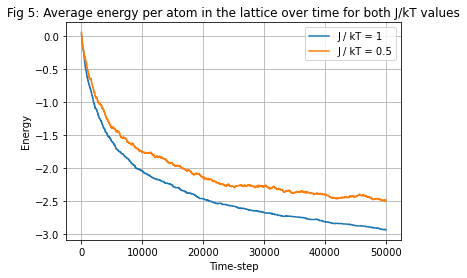

In [8]:
#creating arrays for plotting
iters = np.arange(0,Nsteps+1)
Nspins = boxlen*boxlen
etot_norm2 = etot2/(Nspins * J_over_kT)

#plotting energy over time for both values of J/kT
plt.plot(iters,etot_norm2,label='J / kT = 1')
plt.plot(iters,etot_norm1,label='J / kT = 0.5')
plt.xlabel('Time-step')
plt.ylabel('Energy')
plt.legend()
plt.grid()
plt.title('Fig 5: Average energy per atom in the lattice over time for both J/kT values')

## Conclusion


There is a clear difference between the equilibriation of spins in Fig 2 and Fig 4 above. In Fig 4. much clearer groups of aligned spin states form over time, in Fig 2 these aligned spin groups still exist but are more fragmented with more small pockets of opposite spins within the larger groups. Another difference can be seen between the curves in Fig 5, both curves show the equilibriation method to decrease the energy, however the J/kT = 1 curve is far smoother and decreases to a value of -3 after 50,000 iterations as opposed to the J/kT = 0.5 curve which only decreases to around -2.5.

These differences are most likely as a result of the difference between the spin coupling strength. Where the spin coupling stregth is less strong the criteria of Metropolis' algorithm result in a higher probability of an energy increase when a swap occurs. This leads to a more 'jumpy' decrease in energy as can be seen by the difference in curves in Fig 5. The lower coupling strength also allows the aligned spin groups to be more fragmented as in Fig 2. However in the second simulation the coupling strength was higher and this is shown by more clearly defined aligned spin groups which occur as the smaller fragmented spin groups inbetween are far higher energy and so the algorithm more readily swaps the atoms in these 'fragment' groups. The curve is also smoother as the probability of the energy increasing is far lower due to the higher value of J, as a result of the Metropolis criteria. Furthermore the overall decrease in energy when J/kT = 1 is larger than when J/kT = 0.5 as each time a swap occurs the absolute energy change will be larger due to a larger coupling strength and as the algorithm tends towards negative energy changes, the negative change in energy is larger with a stronger coupling strength.

To improve the accuracy of this simulation the size of the lattice could be increased to create a more realistic intepretation and it would also avoid any wierd behaviour caused by open boundaries.